# Fantasy Football Analysis

In [1]:
# Import neccessary libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## Web Scraping
We're going to use Beautiful Soup to scrape the website. It loops through different drop down arrows, pulling the necessary data.

In [2]:
# Define base URL
base_url = "https://www.footballguys.com/playerhistoricalstats?pos=rb&yr={year}&startwk=1&stopwk=17&profile=p"

In [3]:
# Specify the years we want to scrape
years = range(2000, 2025)

In [13]:
# Initialize an empty list to store the data
all_data = []

# Loop through each year
for year in years:
    url = base_url.format(year=year)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Find the table and extract headers
    table = soup.find("table", class_="datasmall table")
    if table:
        headers = [header.text.strip() for header in table.find_all("th")]
        headers = ["Year"] + headers
        
        # Extract rows
        rows = table.find_all("tr")
        for row in rows:
            cells = row.find_all("td")
            row_data = {
                "Year": year,
                **{headers[i + 1]: cell.text.strip() for i, cell in enumerate(cells)}
            }
            all_data.append(row_data)

,Year,Rank,Name,Age,Exp,G,Rsh,RshYd,Y/Rsh,RshTD,Rec,RecYd,RecTD,FP/G,FantPt
0,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,1,Marshall Faulk STL,27.0,7.0,14,253,1359,5.4,18,81,830,8,32.6,455.9
2,2000,2,Edgerrin James IND,22.0,2.0,16,387,1709,4.4,13,63,594,5,25.1,401.3
3,2000,3,Eddie George TEN,27.0,5.0,16,404,1507,3.7,14,50,453,2,21.4,342.0
4,2000,4,Ahman Green GB,23.0,3.0,16,263,1175,4.5,10,73,559,3,20.3,324.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2000,95,Jonathan Linton BUF,26.0,3.0,5,38,112,2.9,0,2,4,0,2.7,13.6
96,2000,96,Moe Williams MIN,26.0,5.0,9,22,68,3.1,0,3,26,0,1.4,12.4
97,2000,97,Donnell Bennett KC,28.0,7.0,5,24,26,1.1,1,2,17,0,2.5,12.3
98,2000,98,Olandis Gary DEN,25.0,2.0,1,13,80,6.2,0,3,10,0,12.0,12.0


In [19]:
# Create DataFrame
fantasy_df = pd.DataFrame(all_data, columns=headers)
fantasy_df.head(5)

,Year,Rank,Name,Age,Exp,G,Rsh,RshYd,Y/Rsh,RshTD,Rec,RecYd,RecTD,FP/G,FantPt
0,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,1,Marshall Faulk STL,27.0,7.0,14,253,1359,5.4,18,81,830,8,32.6,455.9
2,2000,2,Edgerrin James IND,22.0,2.0,16,387,1709,4.4,13,63,594,5,25.1,401.3
3,2000,3,Eddie George TEN,27.0,5.0,16,404,1507,3.7,14,50,453,2,21.4,342.0
4,2000,4,Ahman Green GB,23.0,3.0,16,263,1175,4.5,10,73,559,3,20.3,324.4


## Tidying the Data

In [20]:
# Drop empty rows
fantasy_df = fantasy_df.dropna(thresh=7)

# Drop unneccessary columns
fantasy_df = fantasy_df.drop(columns=['Rsh', 'RshYd', 'Y/Rsh', 'RshTD', 'Rec', 'RecYd', 'RecTD'])

# Change to correct data types
fantasy_df[['Rank', 'FP/G', 'FantPt', 'Age', 'Exp', 'G']] = fantasy_df[['Rank', 'FP/G', 'FantPt', 'Age', 'Exp', 'G']].astype(float)

# Rename columns
fantasy_df.columns = ['Year', 'Rank', 'Name', 'Age', 'Experience', 'Games_Played', 'Points_Per_Game', 'Total_Points']

# Create 'Team' column
fantasy_df['Team'] = fantasy_df['Name'].apply(lambda x: x.split()[-1] if x.split()[-1].isupper() else '')

fantasy_df.head(5)

,Year,Rank,Name,Age,Experience,Games_Played,Points_Per_Game,Total_Points,Team
1,2000,1.0,Marshall Faulk STL,27.0,7.0,14.0,32.6,455.9,STL
2,2000,2.0,Edgerrin James IND,22.0,2.0,16.0,25.1,401.3,IND
3,2000,3.0,Eddie George TEN,27.0,5.0,16.0,21.4,342.0,TEN
4,2000,4.0,Ahman Green GB,23.0,3.0,16.0,20.3,324.4,GB
5,2000,5.0,Charlie Garner SF,28.0,7.0,16.0,19.2,306.9,SF


## Exploratory Data Analysis

In [23]:
# Total number of rows
total_rows = len(fantasy_df)
print(f'Total Rows: {total_rows}')

# Total number of running backs
unique_rbs = fantasy_df['Name'].nunique()
print(f'Unique RBs: {unique_rbs}')

Total Rows: 3963
Unique RBs: 1803


I don't want the data to be scewed by the many running backs that barely ever played during their career. I only want to look at the running backs that have had an impact. However, I want to see if they've declined over time. In Fantasy Football, you usually have to be a top 30 running back to be useful. So, I'm only going to keep the running backs that at one point in time were in the top 30.

In [26]:
# Identify running backs who have ever ranked 30 or less
rbs_with_top_rank = fantasy_df.groupby('Name')['Rank'].min()
top_rbs = rbs_with_top_rank[rbs_with_top_rank <= 30].index

# Filter the original DataFrame to keep only rows for these top running backs
fantasy_df_filtered = fantasy_df[fantasy_df['Name'].isin(top_rbs)]

fantasy_df_filtered.head(5)


,Year,Rank,Name,Age,Experience,Games_Played,Points_Per_Game,Total_Points,Team
1,2000,1.0,Marshall Faulk STL,27.0,7.0,14.0,32.6,455.9,STL
2,2000,2.0,Edgerrin James IND,22.0,2.0,16.0,25.1,401.3,IND
3,2000,3.0,Eddie George TEN,27.0,5.0,16.0,21.4,342.0,TEN
4,2000,4.0,Ahman Green GB,23.0,3.0,16.0,20.3,324.4,GB
5,2000,5.0,Charlie Garner SF,28.0,7.0,16.0,19.2,306.9,SF


At this point, this is what our final dataset should look like, so I'm good to upload it as a CSV and continue doing EDA.

In [ ]:
fantasy_df_filtered.to_csv('/mnt/data/fantasy.csv', index=False)

In [49]:
# Group by Position and Age, and calculate the mean for Total_Points, Points_Per_Game, and Games_Played
aggregated_df = fantasy_df_filtered.groupby(['Position', 'Age']).agg(
    mean_total_points=('Total_Points', 'mean'),
    mean_points_per_game=('Points_Per_Game', 'mean'),
    total_count=('Name', 'count'),
    mean_games_played=('Games_Played', 'mean')
).reset_index()

# Calculate the total count per position
total_count_per_position = aggregated_df.groupby('Position')['total_count'].transform('sum')

# Calculate the percentage of players in each age group for each position
aggregated_df['percentage_count'] = (aggregated_df['total_count'] / total_count_per_position) * 100

# Display the updated aggregated DataFrame
aggregated_df


,Position,Age,mean_total_points,mean_points_per_game,total_count,mean_games_played,percentage_count
0,qb,21.0,126.600000,10.233333,6,11.500000,0.933126
1,qb,22.0,217.272727,16.868182,22,12.863636,3.421462
2,qb,23.0,222.358537,15.787805,41,13.512195,6.376361
3,qb,24.0,218.607407,15.970370,54,13.444444,8.398134
4,qb,25.0,231.226786,16.308929,56,13.821429,8.709176
...,...,...,...,...,...,...,...
72,wr,35.0,196.408333,14.058333,12,14.666667,1.208459
73,wr,36.0,180.566667,11.588889,9,15.555556,0.906344
74,wr,37.0,202.100000,15.050000,2,13.500000,0.201410
75,wr,40.0,257.100000,16.100000,1,16.000000,0.100705


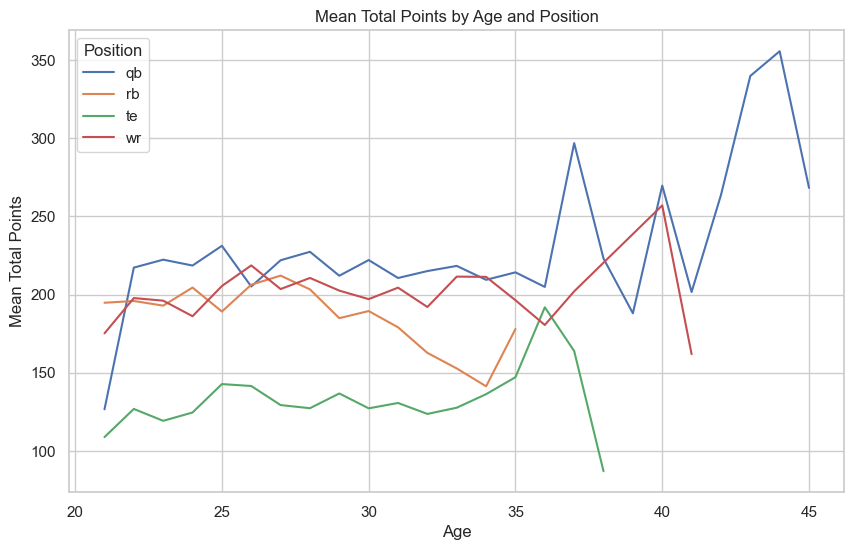

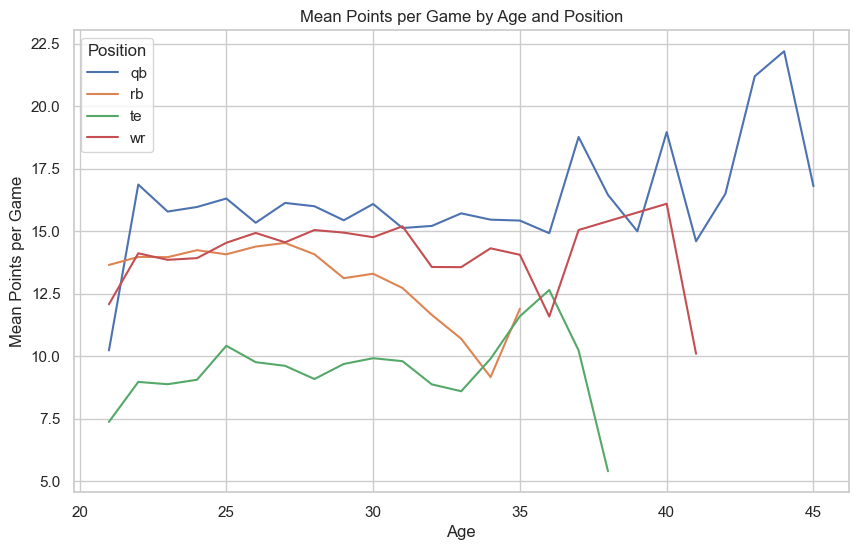

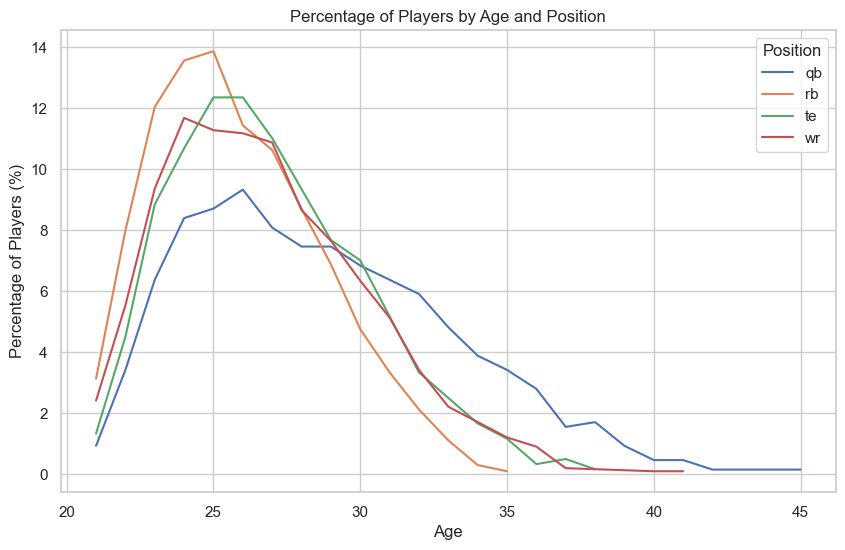

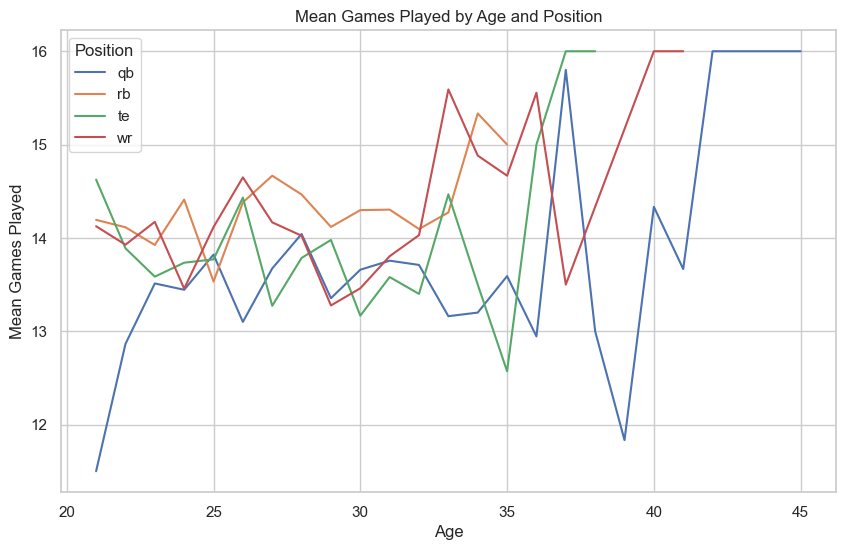

In [50]:
import matplotlib.pyplot as plt

# Plot for Mean Total Points by Age and Position
plt.figure(figsize=(10, 6))
for position in aggregated_df['Position'].unique():
    position_data = aggregated_df[aggregated_df['Position'] == position]
    plt.plot(position_data['Age'], position_data['mean_total_points'], label=position)

plt.title('Mean Total Points by Age and Position')
plt.xlabel('Age')
plt.ylabel('Mean Total Points')
plt.legend(title='Position')
plt.grid(True)
plt.show()

# Plot for Mean Points per Game by Age and Position
plt.figure(figsize=(10, 6))
for position in aggregated_df['Position'].unique():
    position_data = aggregated_df[aggregated_df['Position'] == position]
    plt.plot(position_data['Age'], position_data['mean_points_per_game'], label=position)

plt.title('Mean Points per Game by Age and Position')
plt.xlabel('Age')
plt.ylabel('Mean Points per Game')
plt.legend(title='Position')
plt.grid(True)
plt.show()

# Plot for Percentage Count by Age and Position
plt.figure(figsize=(10, 6))
for position in aggregated_df['Position'].unique():
    position_data = aggregated_df[aggregated_df['Position'] == position]
    plt.plot(position_data['Age'], position_data['percentage_count'], label=position)

plt.title('Percentage of Players by Age and Position')
plt.xlabel('Age')
plt.ylabel('Percentage of Players (%)')
plt.legend(title='Position')
plt.grid(True)
plt.show()

# Plot for Mean Games Played by Age and Position
plt.figure(figsize=(10, 6))
for position in aggregated_df['Position'].unique():
    position_data = aggregated_df[aggregated_df['Position'] == position]
    plt.plot(position_data['Age'], position_data['mean_games_played'], label=position)

plt.title('Mean Games Played by Age and Position')
plt.xlabel('Age')
plt.ylabel('Mean Games Played')
plt.legend(title='Position')
plt.grid(True)
plt.show()


In [51]:
# Group by Year and Position, then calculate the mean age
mean_age_by_year_position = fantasy_df_filtered.groupby(['Year', 'Position']).agg(
    mean_age=('Age', 'mean')
).reset_index()

# Display the new DataFrame
mean_age_by_year_position

,Year,Position,mean_age
0,2000,qb,27.842105
1,2000,rb,26.406250
2,2000,te,23.000000
3,2000,wr,26.222222
4,2001,qb,27.791667
...,...,...,...
95,2023,wr,26.047619
96,2024,qb,27.909091
97,2024,rb,25.852941
98,2024,te,27.750000


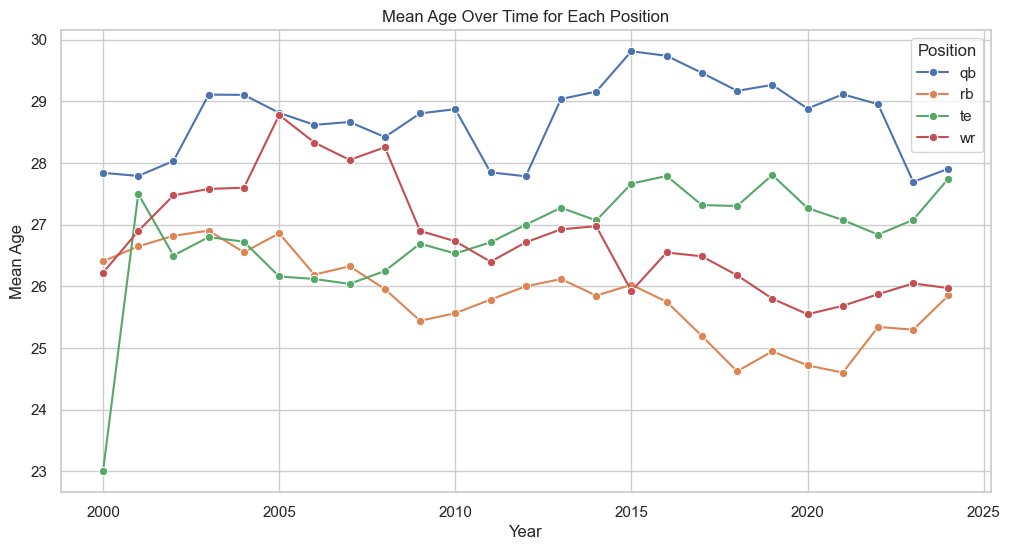

In [52]:

# Set the figure size and style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Plot the mean age over time for each position
sns.lineplot(data=mean_age_by_year_position, x='Year', y='mean_age', hue='Position', marker='o')

# Add titles and labels
plt.title("Mean Age Over Time for Each Position")
plt.xlabel("Year")
plt.ylabel("Mean Age")
plt.legend(title="Position")
plt.show()

In [53]:
# Filter for players over the age of 30
over_30_df = fantasy_df_filtered[fantasy_df_filtered['Age'] > 30]

# Group by Year and Position, then count the occurrences
over_30_count_by_year_position = over_30_df.groupby(['Year', 'Position']).size().reset_index(name='count_over_30')

# Display the new DataFrame
over_30_count_by_year_position


,Year,Position,count_over_30
0,2000,qb,3
1,2000,rb,2
2,2000,wr,3
3,2001,qb,6
4,2001,rb,3
...,...,...,...
91,2023,wr,5
92,2024,qb,4
93,2024,rb,1
94,2024,te,4


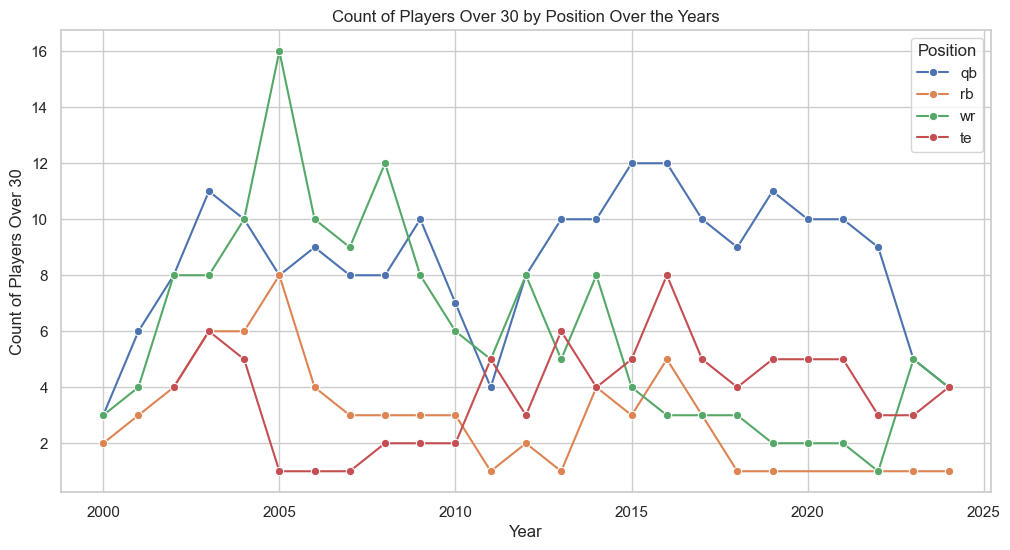

In [54]:
# Set the figure size and style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Plot the count of players over 30 over the years for each position
sns.lineplot(data=over_30_count_by_year_position, x='Year', y='count_over_30', hue='Position', marker='o')

# Add titles and labels
plt.title("Count of Players Over 30 by Position Over the Years")
plt.xlabel("Year")
plt.ylabel("Count of Players Over 30")
plt.legend(title="Position")
plt.show()

In [55]:
import dash
from dash import dcc, html
import plotly.graph_objects as go
import pandas as pd

# Step 1: Prepare your data (same as in your previous code)
fantasy_df_filtered['Start_Year'] = fantasy_df_filtered.groupby('Name')['Year'].transform('min')
fantasy_df_filtered['Experience'] = fantasy_df_filtered['Year'] - fantasy_df_filtered['Start_Year']

# Create a new column for Age, assuming 'Age' is already in the dataset
# Otherwise, you can calculate it from 'Year' or other relevant columns

# Step 2: Filter the original DataFrame to include only the top players
top_players = fantasy_df_filtered[fantasy_df_filtered['Name'].isin(top_10_players_per_position['Name'])]

# Create Dash app
app = dash.Dash(__name__)

# Prepare data for the plot
fig = go.Figure()

# Add traces for each player in each position
for position in top_players['Position'].unique():
    position_data = top_players[top_players['Position'] == position]
    
    for player in position_data['Name'].unique():
        player_data = position_data[position_data['Name'] == player]
        
        fig.add_trace(go.Scatter(
            x=player_data['Age'],  # Change x-axis to Age
            y=player_data['Total_Points'],
            mode='lines+markers',
            name=player,
            visible=False if position != top_players['Position'].unique()[0] else True  # Only show the first position initially
        ))

# Layout with dropdowns for position and player
app.layout = html.Div([
    html.H1("Total Points Over Time by Age"),
    
    # Dropdown for Position
    dcc.Dropdown(
        id='position-dropdown',
        options=[{'label': pos, 'value': pos} for pos in top_players['Position'].unique()],
        value=top_players['Position'].unique()[0],
        style={'width': '30%'}
    ),
    
    # Dropdown for Player (will be updated based on Position)
    dcc.Dropdown(
        id='player-dropdown',
        style={'width': '30%'}
    ),
    
    # Graph for plotting
    dcc.Graph(id='total-points-graph', figure=fig)
])

# Callback to update the player dropdown based on the selected position
@app.callback(
    dash.dependencies.Output('player-dropdown', 'options'),
    dash.dependencies.Input('position-dropdown', 'value')
)
def update_player_dropdown(selected_position):
    # Get the players for the selected position
    players_for_position = top_players[top_players['Position'] == selected_position]['Name'].unique()
    
    # Return the player options for the dropdown
    return [{'label': player, 'value': player} for player in players_for_position]

# Callback to update the plot based on the selected position and player
@app.callback(
    dash.dependencies.Output('total-points-graph', 'figure'),
    [
        dash.dependencies.Input('position-dropdown', 'value'),
        dash.dependencies.Input('player-dropdown', 'value')
    ]
)
def update_graph(selected_position, selected_player):
    fig = go.Figure()

    # Filter data based on position and player
    position_data = top_players[top_players['Position'] == selected_position]
    player_data = position_data[position_data['Name'] == selected_player]
    
    # Add trace for the selected player
    fig.add_trace(go.Scatter(
        x=player_data['Age'],  # Change x-axis to Age
        y=player_data['Total_Points'],
        mode='lines+markers',
        name=selected_player
    ))

    fig.update_layout(
        title=f"Total Points Over Time for {selected_player} ({selected_position} Position)",
        xaxis_title="Age",
        yaxis_title="Total Points",
        template="plotly_white"
    )

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


/var/folders/fn/0m355dy57hlgk4fkg7n62xhc0000gp/T/ipykernel_17817/3734570703.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fn/0m355dy57hlgk4fkg7n62xhc0000gp/T/ipykernel_17817/3734570703.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
fantasy_top_rbs_2024 = fantasy_df[
    (fantasy_df['Rank'] <= 20) &
    (fantasy_df['Position'] == 'rb') &
    (fantasy_df['Year'] == 2024)
]

# Display the filtered DataFrame
fantasy_top_rbs_2024


,Year,Position,Rank,Name,Age,Experience,Games_Played,Points_Per_Game,Total_Points,Team
5722,2024,rb,1.0,Derrick Henry BAL,30.0,9.0,10.0,21.6,215.6,BAL
5723,2024,rb,2.0,Alvin Kamara NO,29.0,8.0,10.0,20.7,206.6,NO
5724,2024,rb,3.0,Bijan Robinson ATL,22.0,2.0,10.0,19.1,190.9,ATL
5725,2024,rb,4.0,Saquon Barkley PHI,27.0,7.0,9.0,20.4,183.9,PHI
5726,2024,rb,5.0,Chuba Hubbard CAR,25.0,4.0,10.0,16.6,166.2,CAR
5727,2024,rb,6.0,Kyren Williams LAR,24.0,3.0,9.0,18.3,165.0,LAR
5728,2024,rb,7.0,Jahmyr Gibbs DET,22.0,2.0,9.0,18.1,162.9,DET
5729,2024,rb,8.0,Breece Hall NYJ,23.0,3.0,10.0,15.4,154.2,NYJ
5730,2024,rb,9.0,De'Von Achane MIA,23.0,2.0,9.0,16.6,149.4,MIA
5731,2024,rb,10.0,James Cook BUF,25.0,3.0,9.0,16.6,149.1,BUF
